In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
import tensorflow as tf 
from tensorflow import keras 
from tqdm import tqdm
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers 
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = "../input/planets-dataset"
os.listdir(path)

['planet', 'test-jpg-additional']

In [3]:
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

In [4]:
pd.read_csv(train_path)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [5]:
pd.read_csv(test_path)

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water


In [6]:
train_df = pd.read_csv(train_path)
train_df.shape

(40479, 2)

In [7]:
test_df = pd.read_csv(test_path)
test_df.shape

(61191, 2)

wow

In [8]:
gc.collect()

0

In [9]:
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


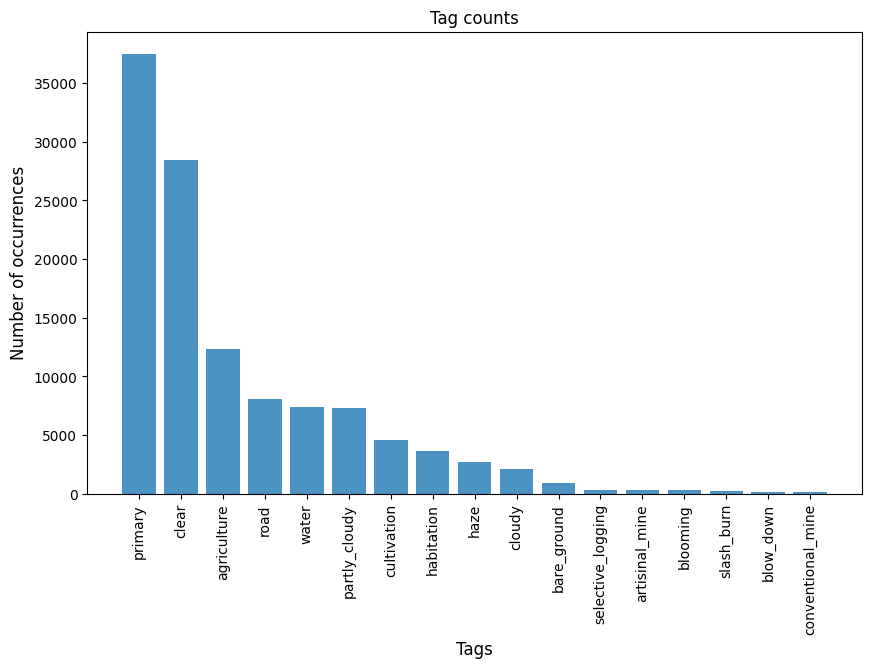

In [10]:
# Tags present in the dataset
tags = train_df['tags'].apply(lambda x: x.split(' '))
tags = [item for sublist in tags for item in sublist]
tag_counts = pd.Series(tags).value_counts()

# Plot the tags
plt.figure(figsize=(10,6))
plt.bar(tag_counts.index, tag_counts.values, alpha=0.8)
plt.title('Tag counts')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.xticks(rotation=90)
plt.show();


In [11]:
labels = set() 

def splitting_tags(tags):
    '''
    Takes in tags column, splits the tags and store as a set 
    '''
    [labels.add(tag) for tag in tags.split()]
    

train_df1 = train_df.copy()
train_df1['tags'].apply(splitting_tags)
labels = list(labels)
print(labels)

['selective_logging', 'clear', 'agriculture', 'water', 'conventional_mine', 'slash_burn', 'cultivation', 'blow_down', 'bare_ground', 'haze', 'artisinal_mine', 'partly_cloudy', 'road', 'primary', 'cloudy', 'habitation', 'blooming']


In [12]:
##One hot encoding is performed on the labels in train classes 
for tag in labels:
    train_df1[tag] = train_df1['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
train_df1['image_name'] = train_df1['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df1.head()

,image_name,tags,selective_logging,clear,agriculture,water,conventional_mine,slash_burn,cultivation,blow_down,bare_ground,haze,artisinal_mine,partly_cloudy,road,primary,cloudy,habitation,blooming
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,train_2.jpg,clear primary,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,train_3.jpg,clear primary,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [13]:
# Define the columns
columns = list(train_df1.columns[2:])
columns

['selective_logging',
 'clear',
 'agriculture',
 'water',
 'conventional_mine',
 'slash_burn',
 'cultivation',
 'blow_down',
 'bare_ground',
 'haze',
 'artisinal_mine',
 'partly_cloudy',
 'road',
 'primary',
 'cloudy',
 'habitation',
 'blooming']

In [14]:
gc.collect()

5222

In [15]:
# Initializing imagedatagenerator with a validation split of 0.2
train_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df1,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_datagen.flow_from_dataframe(dataframe=train_df1,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [16]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [17]:
# Define the model
def cnn_model():
    model = Sequential()

    # Convolution layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=17, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [18]:
#initialize the model
model = cnn_model()

# Preview the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [19]:
# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [20]:
gc.collect()

138

In [21]:
# Fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    callbacks = [earlystop])

Epoch 1/20
1012/1012 [==============================] - 189s 178ms/step - loss: 0.2216 - accuracy: 0.0353 - val_loss: 0.1712 - val_accuracy: 0.0560
Epoch 2/20
1012/1012 [==============================] - 81s 80ms/step - loss: 0.1722 - accuracy: 0.0910 - val_loss: 0.1524 - val_accuracy: 0.0809
Epoch 3/20
1012/1012 [==============================] - 89s 88ms/step - loss: 0.1577 - accuracy: 0.1373 - val_loss: 0.1465 - val_accuracy: 0.1087
Epoch 4/20
1012/1012 [==============================] - 83s 82ms/step - loss: 0.1533 - accuracy: 0.1491 - val_loss: 0.1448 - val_accuracy: 0.1480
Epoch 5/20
1012/1012 [==============================] - 86s 85ms/step - loss: 0.1506 - accuracy: 0.1945 - val_loss: 0.1535 - val_accuracy: 0.1305
Epoch 6/20
1012/1012 [==============================] - 79s 78ms/step - loss: 0.1482 - accuracy: 0.1934 - val_loss: 0.1444 - val_accuracy: 0.1209
Epoch 6: early stopping


In [22]:
gc.collect()

21

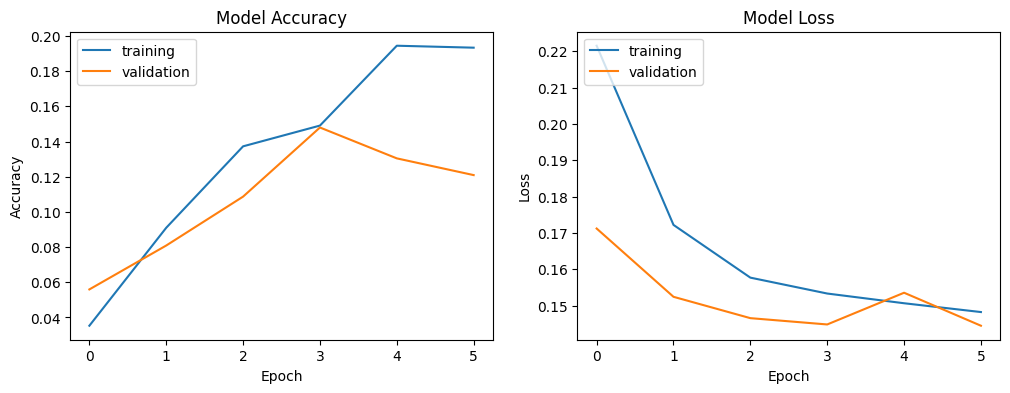

In [23]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [24]:
gc.collect()

7807

In [25]:
model1 = cnn_model()

In [26]:
##adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission1 = sample_submission.copy()
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [27]:
# Divide the sample submission file into two splits,
# first test1_df contains the first 40669 images 
test_df1 = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [28]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))

Found 40669 validated image filenames.


In [29]:
#first, we reset the test generator to avoid shuffling of index 
test_gen.reset()
pred = model1.predict(test_gen, steps=step_test_size1, verbose=1)

1271/1271 [==============================] - 175s 138ms/step


In [30]:
# Get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# Convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

,image_name,tags
0,test_0.jpg,clear agriculture cultivation blow_down partly...
1,test_1.jpg,clear agriculture cultivation blow_down partly...
2,test_2.jpg,clear agriculture blow_down partly_cloudy primary
3,test_3.jpg,clear agriculture cultivation blow_down partly...
4,test_4.jpg,clear agriculture blow_down partly_cloudy prim...


In [31]:
gc.collect()

0

In [32]:
#second batch of the test dataset
additional_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [33]:
#creating a generator for the second batch of test image files
test_gen1 = test_datagen.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 20522 validated image filenames.


In [34]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_gen1.reset()
pred1 = model1.predict(test_gen1, steps = step_test_size2, verbose = 1)

642/642 [==============================] - 89s 138ms/step


In [35]:
#this is to get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

#convert the predicted values to a dataframe
#join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result2.head()

,image_name,tags
0,file_0.jpg,clearagriculturecultivationblow_downpartly_clo...
1,file_1.jpg,agricultureconventional_mineblow_downpartly_cl...
2,file_10.jpg,clearagriculturecultivationblow_downpartly_clo...
3,file_100.jpg,clearagriculturecultivationblow_downpartly_clo...
4,file_1000.jpg,clearagriculturecultivationblow_downpartly_clo...


In [36]:
# Final result of the predicted tags for the test images,
# we need to concat the first and second results in 
#that order to avoid shuffling the index
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear agriculture cultivation blow_down partly...
1,test_1.jpg,clear agriculture cultivation blow_down partly...
2,test_2.jpg,clear agriculture blow_down partly_cloudy primary
3,test_3.jpg,clear agriculture cultivation blow_down partly...
4,test_4.jpg,clear agriculture blow_down partly_cloudy prim...


In [37]:
# Remove the .jpg extension from the image_name of the last_result 
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,clear agriculture cultivation blow_down partly...
1,test_1,clear agriculture cultivation blow_down partly...
2,test_2,clear agriculture blow_down partly_cloudy primary
3,test_3,clear agriculture cultivation blow_down partly...
4,test_4,clear agriculture blow_down partly_cloudy prim...


In [38]:
# Finally, we save the result to a csv file using the .to_csv() 
# method and setting the index to false.
final_df.to_csv('submission2.csv', index = False)